In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

os.chdir("..")
from scripts.image_preprocessing import contrast_enhancement

In [7]:
image_dir = "dataset/sampleplates"
images = []

for image_file in os.listdir(image_dir):
    image_path = os.path.join(image_dir, image_file)
    image = cv2.imread(image_path)

    images.append(image)

In [8]:
def verify_plate_characters(plate_candidate, gray_image):
    (x, y, w, h) = cv2.boundingRect(plate_candidate)
    if w == 0 or h == 0:
        return False
        
    plate_region = gray_image[y:y+h, x:x+w]
    
    if plate_region.size == 0:
        return False

    binary_plate = cv2.threshold(plate_region, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    
    char_contours, _ = cv2.findContours(binary_plate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    char_count = 0
    min_char_height = 0.2 * h
    max_char_height = 0.65 * h
    max_char_width = 0.2 * w

    for i, char_c in enumerate(char_contours):
        (cx, cy, cw, ch) = cv2.boundingRect(char_c)
        
        if ch > min_char_height and ch < max_char_height and cw < max_char_width:
            aspect_ratio = ch / float(cw)
            if aspect_ratio > 1.2 and aspect_ratio < 5.0:
                char_count += 1
                
    return char_count >= 3 and char_count <= 10

In [10]:
def find_plate_candidates(image):
    gray = cv2.split(cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb))[0]
    
    contrast_enhanced = contrast_enhancement(gray)
    
    blurred = cv2.GaussianBlur(contrast_enhanced, (11, 11), 0)
    
    sobelx = cv2.Sobel(blurred, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
    sobelx = np.absolute(sobelx)
    (min_val, max_val) = (np.min(sobelx), np.max(sobelx))
    sobelx = 255 * ((sobelx - min_val) / (max_val - min_val))
    sobelx = sobelx.astype("uint8")

    plt.figure(figsize=(12, 8))
    plt.subplot(1, 3, 1)
    plt.imshow(sobelx, cmap="gray")
    plt.axis('off')
    plt.title('Sobelx')

    grad_thresh = cv2.threshold(sobelx, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    grad_thresh = cv2.morphologyEx(grad_thresh, cv2.MORPH_CLOSE, rect_kernel)
    
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 7))
    thresh = cv2.morphologyEx(grad_thresh, cv2.MORPH_CLOSE, rect_kernel)
    thresh = cv2.erode(thresh, None, iterations=4)
    thresh = cv2.dilate(thresh, None, iterations=6)

    plt.subplot(1, 3, 2)
    plt.imshow(thresh, cmap="gray")
    plt.axis('off')
    plt.title('Final Mask')
    
    contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    candidate_regions = []
    image_with_contours = image.copy()
    
    for contour in contours:
        rect = cv2.minAreaRect(contour)
        (x, y), (width, height), angle = rect

        if width == 0 or height == 0:
            continue

        area = width * height
        if area < 2000 or area > 50000:
            continue

        aspect_ratio = max(width, height) / min(width, height)
        
        if not (1 < aspect_ratio < 2 or 3 < aspect_ratio < 7):
            continue
            
        if verify_plate_characters(contour, gray):
            x, y, w, h = cv2.boundingRect(contour)
            cv2.rectangle(image_with_contours, (x, y), (x + w, y + h), (0, 0, 255), 2)
            candidate_regions.append(contour)

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Plate')
    plt.show()
                    
    return candidate_regions

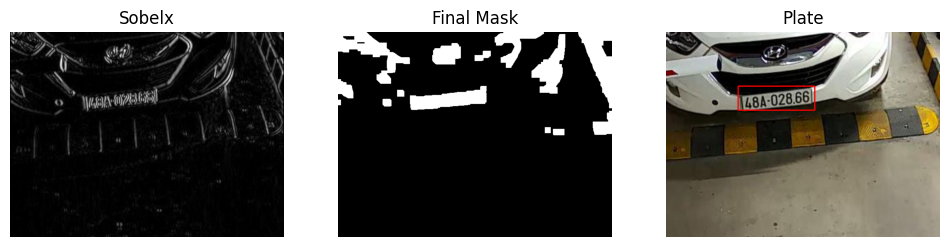

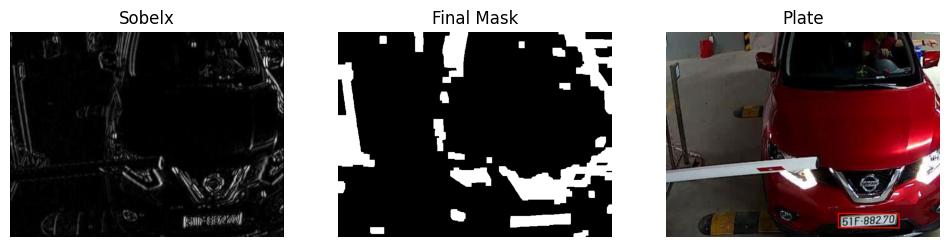

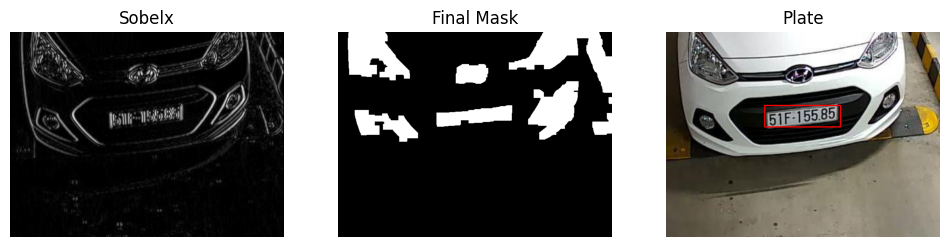

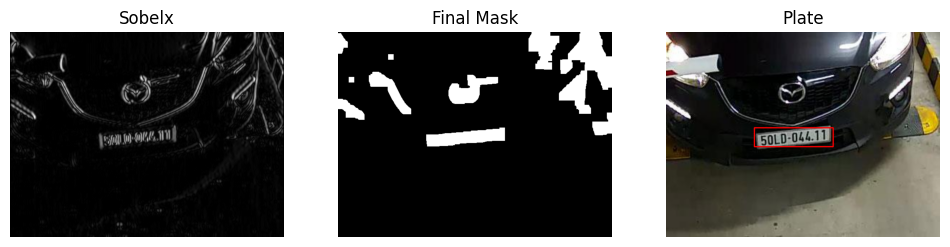

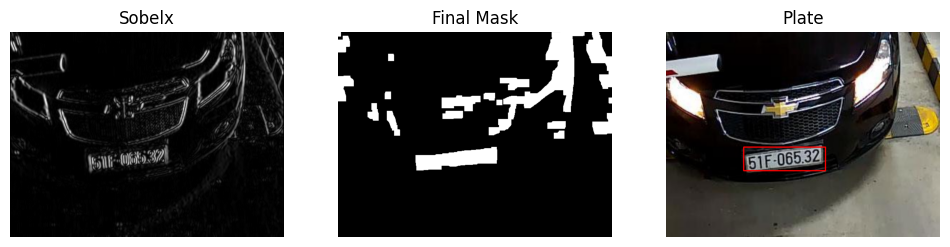

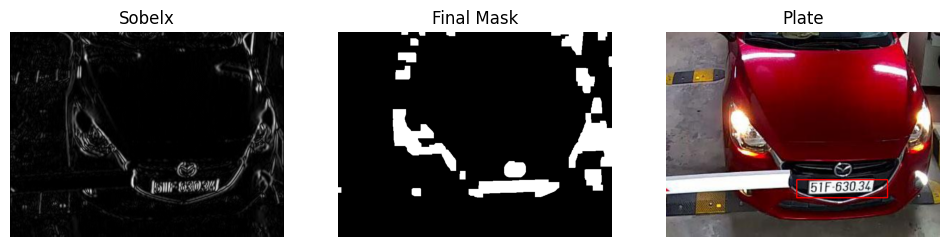

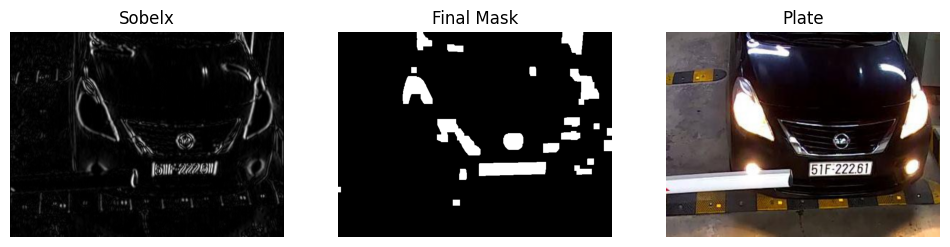

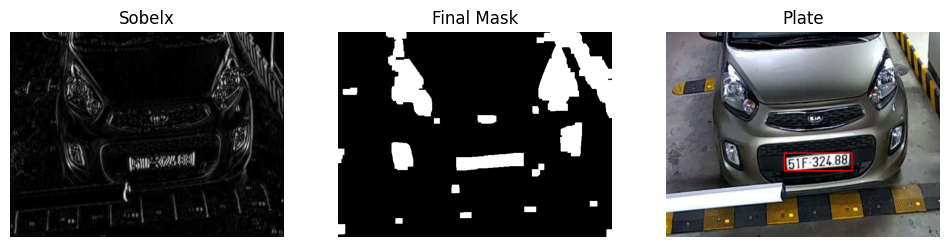

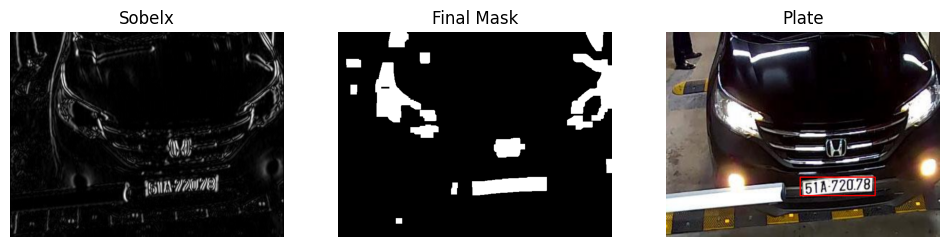

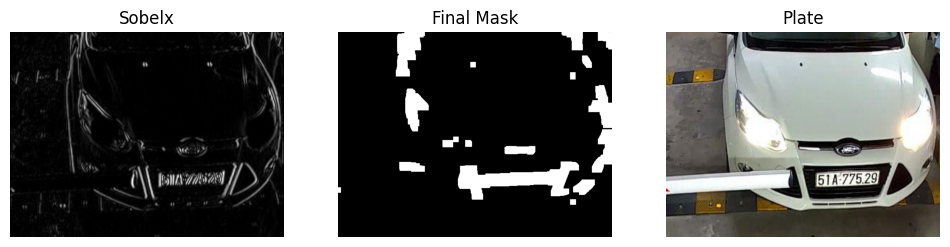

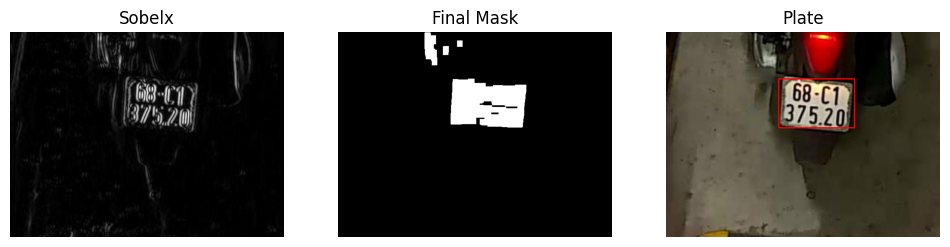

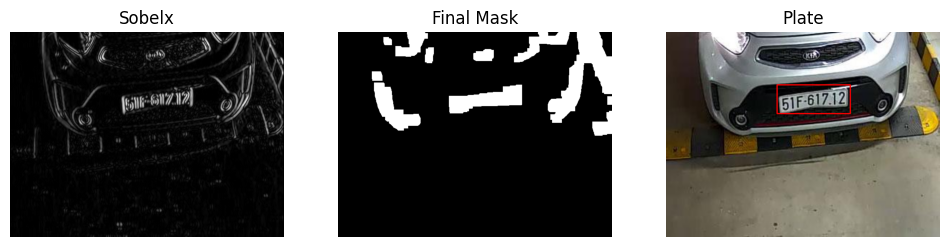

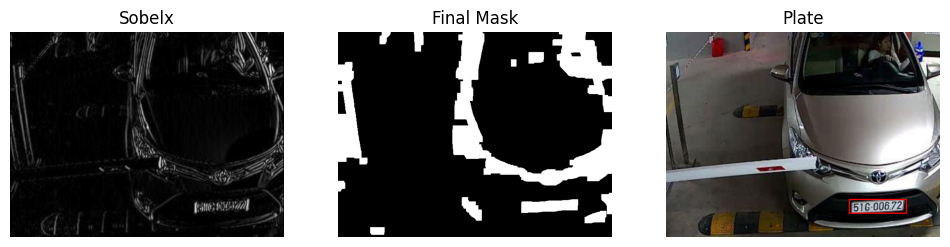

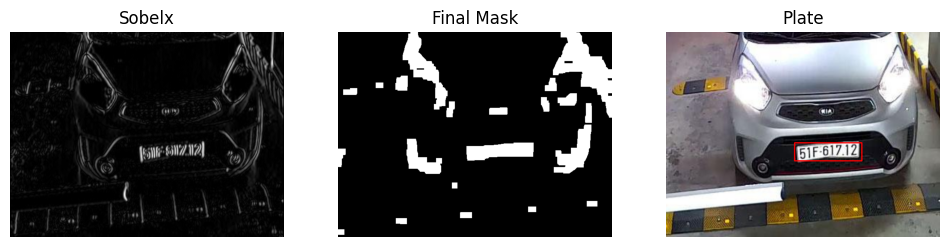

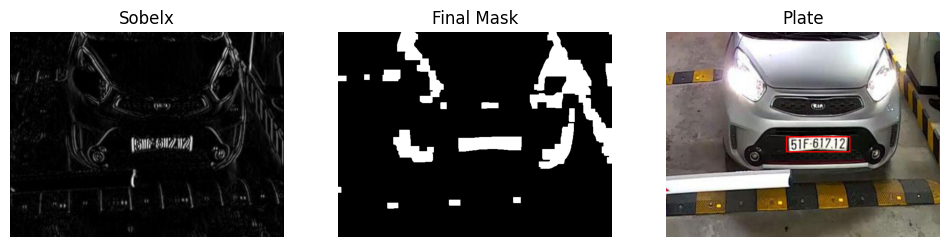

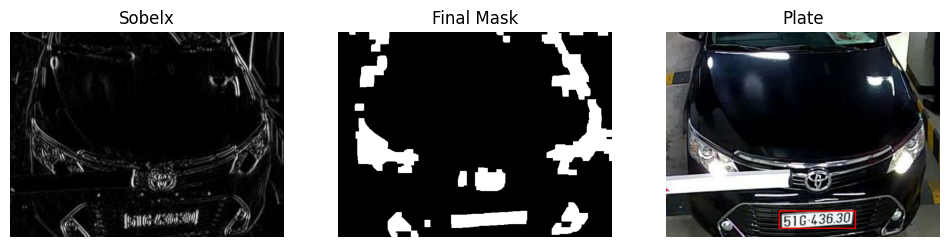

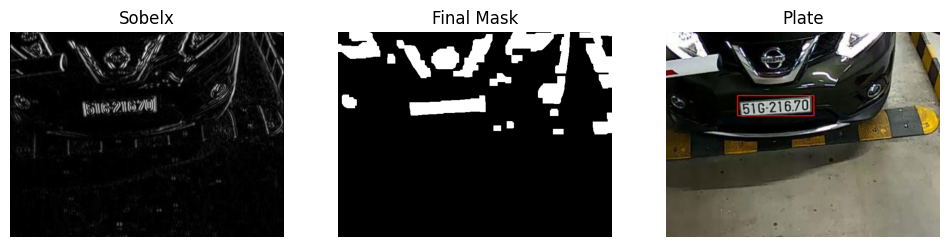

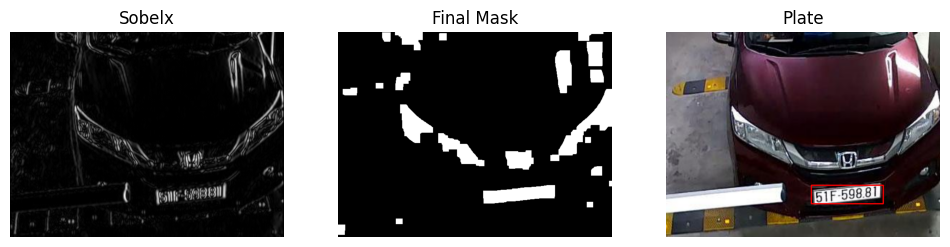

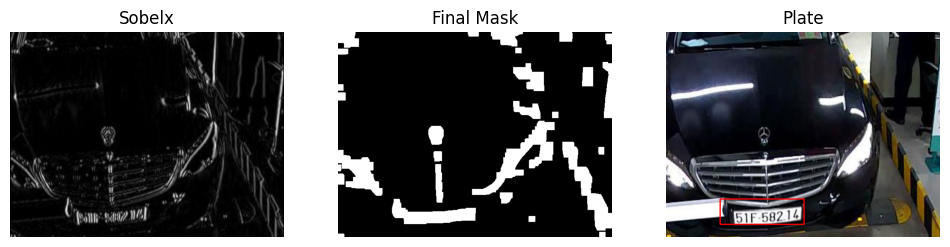

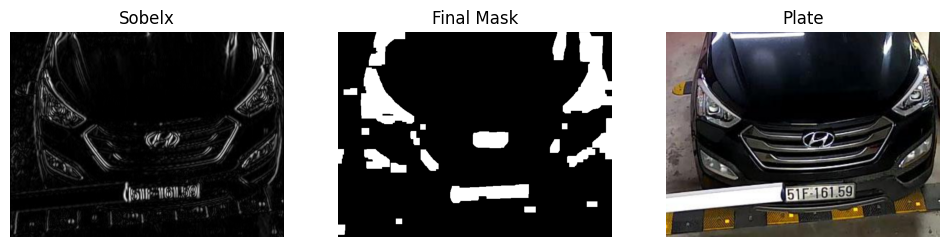

In [11]:
for index, image in enumerate(images):
    image = cv2.resize(image, (640, 480))
    candidates = find_plate_candidates(image)